### Objective: To apply Random Forest and XGBoost on Amazon Fine Food Reviews

In [169]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [171]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


In [172]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [173]:
# Loading data 
customer_reviews = pd.read_csv('../input/Reviews.csv')
customer_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [174]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [175]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [176]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [177]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [178]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [179]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [180]:

# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [181]:
#nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



{'into', 'no', 'm', 'be', 'when', 'itself', 'haven', 's', "haven't", 't', 'who', 'didn', "she's", 'after', 'yours', "it's", 'this', "should've", 'an', 'has', 'off', 'both', 'being', "won't", 'wasn', 'you', 'that', 'just', 'our', 'why', 'with', 'whom', 'him', 'should', 'it', 'while', 'up', 'y', 'me', 'hers', 'its', 'he', "wasn't", 'were', 'did', 'how', 'once', 'of', 'any', 'other', 'doesn', 'above', 'she', 'yourself', 'mustn', 'himself', 'between', 'd', 'yourselves', 'own', "mustn't", 'because', "you're", 'each', 'do', 'during', 'a', "shan't", 'under', "doesn't", 'does', 'there', 'hadn', 'and', 'their', 'until', "don't", "you'd", 'we', 'what', 'over', 'if', 'now', 'can', 'shan', 'too', 'down', 'had', 'which', 'ain', 'they', 'for', 'from', "you've", 'won', 'more', 'in', 'will', "isn't", 'same', 'couldn', "hadn't", 'theirs', "wouldn't", 'myself', "couldn't", 'again', 'am', 'doing', 'on', 'against', 'to', 'shouldn', "that'll", 'have', 'such', 'through', 'wouldn', 'out', 'before', 'only', '

In [182]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


In [183]:
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [184]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
            
        

In [185]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [186]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g...",love book miss hard cover version grew read se...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...,chicken soup rice month fun way children learn...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...,good swingi rhythm read aloud great littl book...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...,great way learn month book poetri month year g...


### Observation:
Dataset is highly imbalanced. Out of 364171 reviews only 57110 reviews are negative and rest are positive. 
 

In [187]:
# sorting whole  data based on time
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)

#sampled_data.sort_values('Time',axis=0,kind="quicksort", ascending=True , inplace = True)

In [188]:
b.head(20) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like books or movies.

In [189]:
# removing reviews that belong to other products
regex =  re.compile(r'book|entertaining|funny|movie|show|film|series|educational|storyteller|comedic') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )

In [190]:
# Number of reviews left
b.shape

(353205, 12)

In [191]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


Checking if text length could be used as a feature for calssification

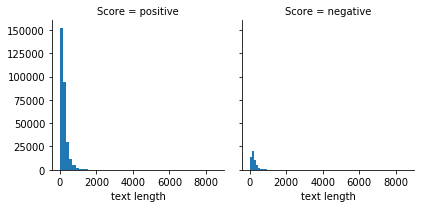

In [192]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)
plt.show()

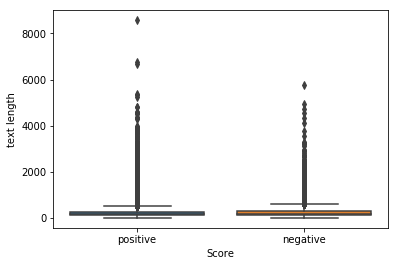

In [193]:
sns.boxplot(x='Score', y='text length', data=b)
plt.show()

It seems clearer from above plots that text length  won't be a helpful featurer for classification

### Function for standardizing data

In [194]:
from sklearn.preprocessing import StandardScaler

In [195]:

def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [196]:
# taking top 100k points from whole dataset
sampled_data = b.head(100000)

In [197]:
sampled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


In [198]:
sampled_data['text length']

76881     172
374449    633
1244      116
1243      250
131216    275
149769    152
149788    108
149767    198
374448    347
149791    138
374334    321
361316    399
479722    356
479729    252
361308    423
374356    177
479727    379
479723    367
149784    490
361310    141
149786     56
149700    351
149701    592
149699    334
245107    875
149785    320
479724    240
361309    606
479735    113
374327    157
         ... 
326989    310
91791     218
90857     649
304295    297
115401    196
525383    133
51999     237
85361     640
427527    146
166404     98
142462    202
47396     134
172368     93
206567    134
501417    102
367336    366
162839     52
401969     67
157107    190
498899    486
101731    309
370289     98
358177     70
112371    255
37135     192
197247    118
129113     96
355012    112
27258     174
261250    157
Name: text length, Length: 100000, dtype: int64

In [199]:
# breaking data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1
    else:
        return -1
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test  , len_train , len_test= train_test_split(sampled_data['CleanedText'],sampled_data['Score'],sampled_data['text length'] ,test_size=0.3, random_state=45)

In [200]:
Y_train.value_counts()

 1    61338
-1     8662
Name: Score, dtype: int64

## Bag of Words

#### Vectorizing & Standarzing both train and test data

In [135]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts
# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,2) , dtype = 'float' ,min_df = 100) # considering only relevent words
# min_df--> ignoring terms that appear in less than 9 documents
#max_df---> ignore terms that appear in more than 60% documents

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (70000, 3664)
Test Dataset:  (30000, 3664)


## ***Random Forest on BOW*******

In [136]:
from sklearn.ensemble import RandomForestClassifier

### ***Random Forest:*** RFs train each tree independently, using a random sample of the data. This randomness helps to make the model more robust than a single decision tree, and less likely to overfit on the training data

In [137]:
# taking number of base models (n_estimators) and maximum depth(max_depth) of each Decision Tree as hyperparameter
param_grid = { 'n_estimators' : [50 , 100 , 150],
              'max_depth': [ 10,30,50,70 , 90]   }  

In [138]:
rf = RandomForestClassifier(max_features='sqrt' , random_state = 40 ) 
tscv = TimeSeriesSplit(n_splits=3) 
rf_CV  = GridSearchCV(estimator=rf, param_grid=param_grid , cv = tscv , scoring = 'roc_auc' , n_jobs = -1)
rf_CV.fit(bow_X_train_matrix , Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [139]:
print(" best parameter:" , rf_CV.best_params_)
print("best parameter score:" ,rf_CV.best_score_ )

 best parameter: {'max_depth': 90, 'n_estimators': 150}
best parameter score: 0.9284743797387146


In [140]:
grid = rf_CV.cv_results_.get('mean_test_score')
grid

array([0.90338564, 0.9082421 , 0.91241014, 0.91993023, 0.92273571,
       0.92466528, 0.921995  , 0.92578362, 0.92773898, 0.92136729,
       0.92649066, 0.92796275, 0.92186499, 0.92699533, 0.92847438])

In [141]:
score_table= grid.reshape(3,5)

### ***HeatMap***

Text(69,0.5,'number of estimator')

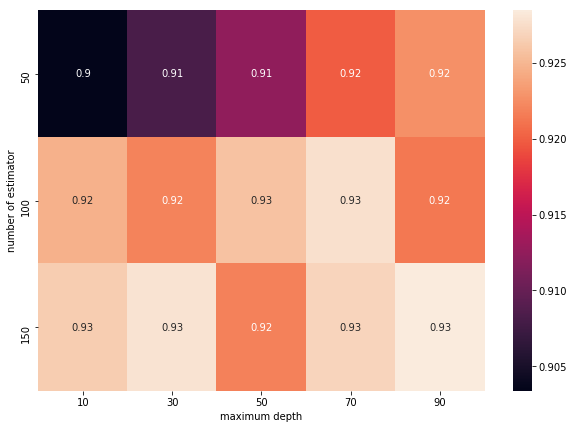

In [142]:
score_table= grid.reshape(3,5)
ind = [50,100,150]
col = [10,30,50,70 , 90]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('maximum depth')
plt.ylabel('number of estimator')

Test accuracy:  0.9222666666666667
              precision    recall  f1-score   support

          -1       0.92      0.37      0.53      3546
           1       0.92      1.00      0.96     26454

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.92      0.69      0.75     30000
weighted avg       0.92      0.92      0.91     30000



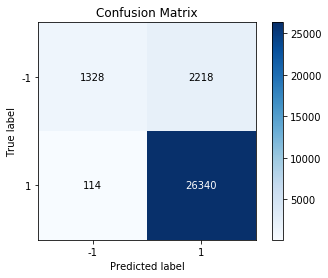

In [143]:
# training model using random forest
rf = RandomForestClassifier(n_estimators=rf_CV.best_params_['n_estimators'], max_depth =rf_CV.best_params_['max_depth'] , n_jobs=-1)
rf.fit(bow_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',rf.score(bow_X_test_matrix , Y_test))


test_prediction = rf.predict(bow_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


## Important Features

In [144]:
from wordcloud import WordCloud, STOPWORDS

In [145]:
importances = rf.feature_importances_
#imp_values = np.sort(importances)[::-1][:20]
top_words = np.argsort(importances)[::-1][:30]
names = count_vect.get_feature_names()
imp_feat = {}
for i in range(len(top_words)):
    imp_feat.update({names[top_words[i]]:len(top_words)-i})

In [146]:
# important features
imp_feat

{'disappoint': 30,
 'not': 29,
 'great': 28,
 'worst': 27,
 'best': 26,
 'terribl': 25,
 'love': 24,
 'aw': 23,
 'horribl': 22,
 'not worth': 21,
 'bad': 20,
 'not good': 19,
 'wast money': 18,
 'not buy': 17,
 'good': 16,
 'wast': 15,
 'delici': 14,
 'return': 13,
 'money': 12,
 'not recommend': 11,
 'yuck': 10,
 'poor': 9,
 'threw': 8,
 'tast': 7,
 'would not': 6,
 'excel': 5,
 'refund': 4,
 'stale': 3,
 'receiv': 2,
 'bewar': 1}

### *** WordCloud***

In [147]:
wc = WordCloud(width=3000,height=2000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(imp_feat)

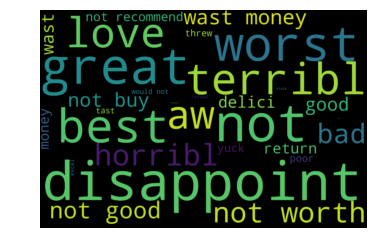

In [148]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## ***XGBoost***: It is an implementation of gradient boosted decision trees designed for speed and performance.

### XG Boosting on BOW

In [149]:
import xgboost as xgb

In [150]:
base_models = [50 , 100 , 150] # base learners
# shrinkage/learning rate
v = [0.05,0.1,0.2,0.3]   
param_grid = {'n_estimators': base_models,  'learning_rate':v}
xgb_model = xgb.XGBClassifier(max_depth = 4)
xgb_CV = GridSearchCV(xgb_model,param_grid,cv = 3 ,n_jobs = -1 ,  verbose=1)
xgb_CV.fit(bow_X_train_matrix , Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [151]:
print(" best parameter:" , xgb_CV.best_params_)
print("best parameter score:" ,xgb_CV.best_score_ )

 best parameter: {'learning_rate': 0.3, 'n_estimators': 150}
best parameter score: 0.9343


In [152]:
grid = xgb_CV.cv_results_.get('mean_test_score')
grid

array([0.89072857, 0.90188571, 0.90955714, 0.90201429, 0.91591429,
       0.92201429, 0.91602857, 0.92602857, 0.93044286, 0.92255714,
       0.93067143, 0.9343    ])

In [153]:
score_table= grid.reshape(3,4)

In [154]:
ind = [50,100,150]         # base learners
col = [0.05,0.1,0.2,0.3]   # shrinkage/learning rate
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

Text(69,0.5,'number of estimator')

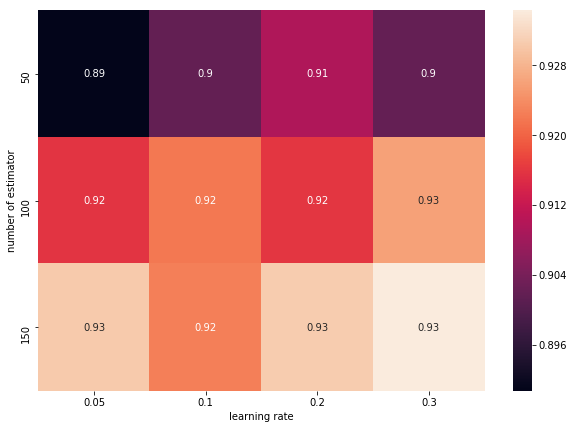

In [155]:
plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('learning rate')
plt.ylabel('number of estimator')

Test accuracy:  0.9363333333333334
              precision    recall  f1-score   support

          -1       0.85      0.56      0.68      3546
           1       0.94      0.99      0.96     26454

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.90      0.77      0.82     30000
weighted avg       0.93      0.94      0.93     30000



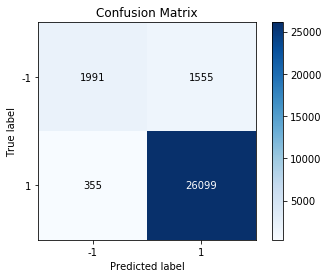

In [156]:
xgbdt = xgb.XGBClassifier(n_estimators =xgb_CV.best_params_['n_estimators'] , learning_rate = xgb_CV.best_params_['learning_rate'] , max_depth = 4 , n_jobs = -1 )
xgbdt.fit(bow_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',xgbdt.score(bow_X_test_matrix , Y_test))


test_prediction = xgbdt.predict(bow_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


## Important Features 

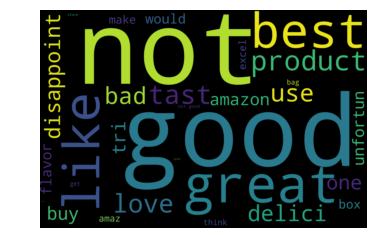

In [157]:
importances = xgbdt.feature_importances_
#imp_values = np.sort(importances)[::-1][:20]
top_words = np.argsort(importances)[::-1][:30]
names = count_vect.get_feature_names()
imp_feat = {}
for i in range(len(top_words)):
    imp_feat.update({names[top_words[i]]:len(top_words)-i})
    
wc = WordCloud(width=3000,height=2000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(imp_feat)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# TF-IDF

In [158]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)  ,min_df = 100 )
# Transforming train/test data into tf-idf
tfidf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tfidf_X_train_matrix.shape)
tfidf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tfidf_X_test_matrix.shape)

(70000, 3664)
(30000, 3664)


### ***Random Forest on tfidf***

In [159]:
# hyperparameter
param_grid = {  'n_estimators' : [50,100,150],
              'max_depth': [ 10,30,50,70 , 90]   }  

# cross validation
rf = RandomForestClassifier(max_features='sqrt'  , random_state = 40 ) 
tscv = TimeSeriesSplit(n_splits=3) 
rf_CV  = GridSearchCV(estimator=rf, param_grid=param_grid , cv = tscv , scoring = 'roc_auc' , n_jobs = -1)
rf_CV.fit(tfidf_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [160]:
# best hyperparameter
print(" best parameter:" , rf_CV.best_params_)
print("best parameter score:" ,rf_CV.best_score_ )

 best parameter: {'max_depth': 90, 'n_estimators': 150}
best parameter score: 0.9365716008358934


### ***HeatMap***

Text(69,0.5,'number of estimator')

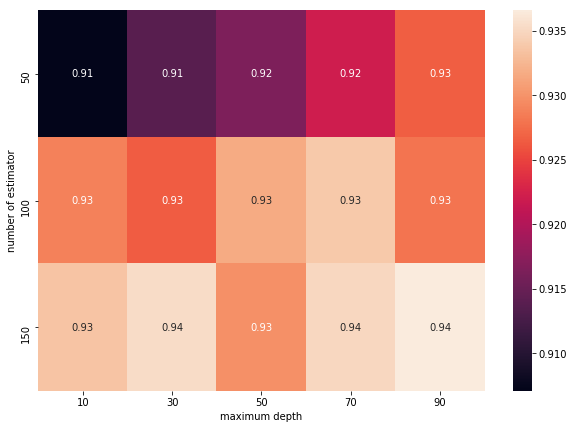

In [161]:
# heatmap
grid = rf_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,5)
ind = [50,100,150]
col = [10,30,50,70 , 90]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('maximum depth')
plt.ylabel('number of estimator')

Test accuracy:  0.9225
              precision    recall  f1-score   support

          -1       0.93      0.37      0.53      3546
           1       0.92      1.00      0.96     26454

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.93      0.68      0.75     30000
weighted avg       0.92      0.92      0.91     30000



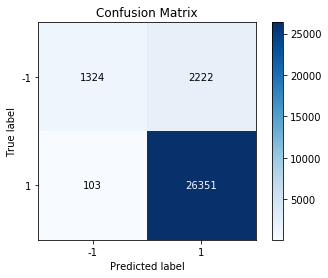

In [162]:
# training and testing
rf = RandomForestClassifier(n_estimators=rf_CV.best_params_['n_estimators'], max_depth =rf_CV.best_params_['max_depth'] , n_jobs=-1)
rf.fit(tfidf_X_train_matrix , Y_train)

# testing accuracy
print('Test accuracy: ',rf.score(tfidf_X_test_matrix , Y_test))

#predicted output
test_prediction = rf.predict(tfidf_X_test_matrix)
print(classification_report(Y_test, test_prediction))

#confusion matrix
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

### ***Important Features***

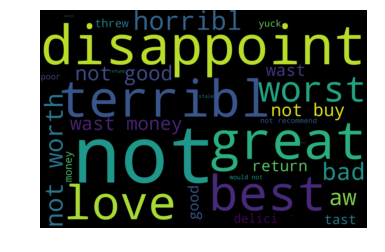

In [163]:
#printng important features
importances = rf.feature_importances_

# taking top 30 features
top_words = np.argsort(importances)[::-1][:30]

names = tf_idf_vect.get_feature_names()
imp_feat = {}
for i in range(len(top_words)):
    imp_feat.update({names[top_words[i]]:len(top_words)-i})
    
# using word cloud to print important features
wc = WordCloud(width=3000,height=2000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(imp_feat)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## XGBoost on tf-Idf

In [164]:
base_models = [50 , 100 ,150]         # base learners
# shrinkage/learning rate
v = [0.05,0.1,0.2,0.3]                      
param_grid = {'n_estimators': base_models,  'learning_rate':v}

# cross validation 
xgb_model = xgb.XGBClassifier(max_depth = 4) 
xgb_CV = GridSearchCV(xgb_model,param_grid,cv = 3 ,n_jobs = -1 ,  verbose=1)
xgb_CV.fit(tfidf_X_train_matrix , Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [165]:
# best hyperparameters
print(" best parameter:" , xgb_CV.best_params_)
print("best parameter score:" ,xgb_CV.best_score_ )

 best parameter: {'learning_rate': 0.3, 'n_estimators': 150}
best parameter score: 0.9346857142857142


### ***HeatMap***

Text(69,0.5,'no. of estimators')

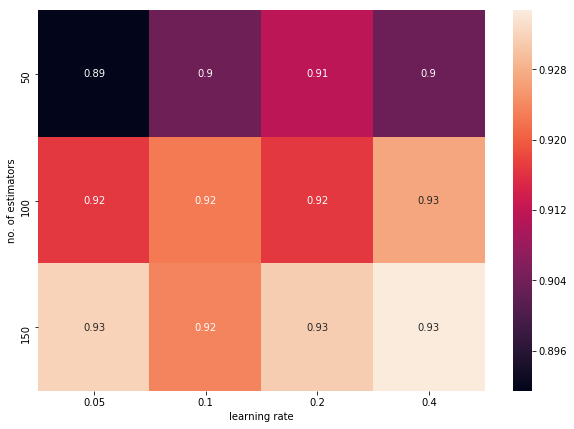

In [166]:
# heat map
grid = xgb_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,4)
ind = [50,100 , 150]
col =  [0.05,0.1,0.2,0.4] 
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('learning rate')
plt.ylabel('no. of estimators')

Test accuracy:  0.939
              precision    recall  f1-score   support

          -1       0.86      0.58      0.69      3546
           1       0.95      0.99      0.97     26454

   micro avg       0.94      0.94      0.94     30000
   macro avg       0.90      0.78      0.83     30000
weighted avg       0.94      0.94      0.93     30000



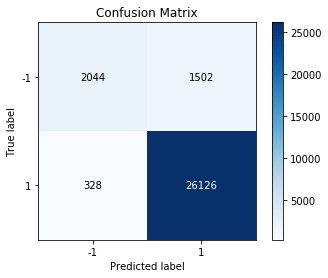

In [167]:
# training and testing of model
xgbdt = xgb.XGBClassifier(n_estimators =xgb_CV.best_params_['n_estimators'] , learning_rate = xgb_CV.best_params_['learning_rate'] , max_depth = 4 , n_jobs = -1 )
xgbdt.fit(tfidf_X_train_matrix , Y_train)

# testing accuracy
print('Test accuracy: ',xgbdt.score(tfidf_X_test_matrix , Y_test))

# testing prediction
test_prediction = xgbdt.predict(tfidf_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

### Important Features

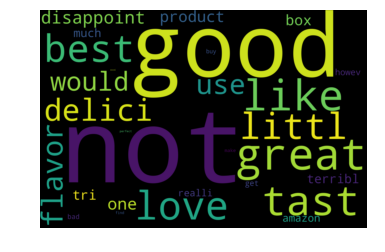

In [168]:
importances = xgbdt.feature_importances_

top_words = np.argsort(importances)[::-1][:30]
names = tf_idf_vect.get_feature_names()
imp_feat = {}
for i in range(len(top_words)):
    imp_feat.update({names[top_words[i]]:len(top_words)-i})
    
wc = WordCloud(width=3000,height=2000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(imp_feat)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Avg Word2Vec

In [91]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)

In [92]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)



## Random Forest on Avg Word2Vec

In [93]:
param_grid = {  'n_estimators' : [50,100,150],
              'max_depth': [ 10,30,50,70 , 90]   }  
rf = RandomForestClassifier(max_features='sqrt'  , random_state = 40 ) 
tscv = TimeSeriesSplit(n_splits=3) 
rf_CV  = GridSearchCV(estimator=rf, param_grid=param_grid , cv = tscv , scoring = 'roc_auc' , n_jobs = -1)
rf_CV.fit(w2vec_X_train_matrix , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [94]:
# best hyperparameter
print(" best parameter:" , rf_CV.best_params_)
print("best parameter score:" ,rf_CV.best_score_ )

 best parameter: {'max_depth': 30, 'n_estimators': 150}
best parameter score: 0.9131160216595869


### *** HeatMap***

Text(69,0.5,'no. of estimator')

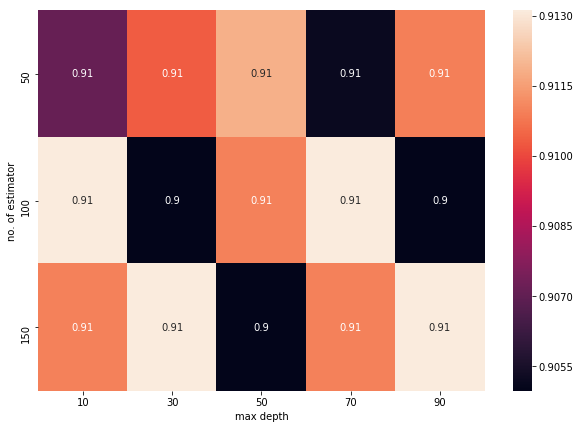

In [95]:
grid = rf_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,5)
ind = [50,100,150]
col = [10,30,50,70 , 90]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('max depth')
plt.ylabel('no. of estimator')

Test accuracy:  0.9124
              precision    recall  f1-score   support

          -1       0.83      0.33      0.47      3546
           1       0.92      0.99      0.95     26454

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.87      0.66      0.71     30000
weighted avg       0.91      0.91      0.90     30000



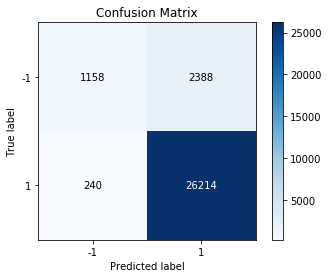

In [97]:
rf = RandomForestClassifier(n_estimators=rf_CV.best_params_['n_estimators'], max_depth =rf_CV.best_params_['max_depth'] , n_jobs=-1)
rf.fit(w2vec_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',rf.score(w2vec_X_test_matrix , Y_test))


test_prediction = rf.predict(w2vec_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

## Gradient Boosting

In [98]:
base_models = [50,100 ,150]
v = [0.05,0.1,0.2,0.4]
param_grid = {'n_estimators': base_models,  'learning_rate':v}
xgb_model = xgb.XGBClassifier(max_depth = 4)
xgb_CV = GridSearchCV(xgb_model,param_grid,cv = 3 ,n_jobs = -1 ,  verbose=1)
xgb_CV.fit(w2vec_X_train_matrix , Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [99]:
print(" best parameter:" , xgb_CV.best_params_)
print("best parameter score:" ,xgb_CV.best_score_ )

 best parameter: {'learning_rate': 0.2, 'n_estimators': 150}
best parameter score: 0.9188714285714286


Text(69,0.5,'no. of estimators')

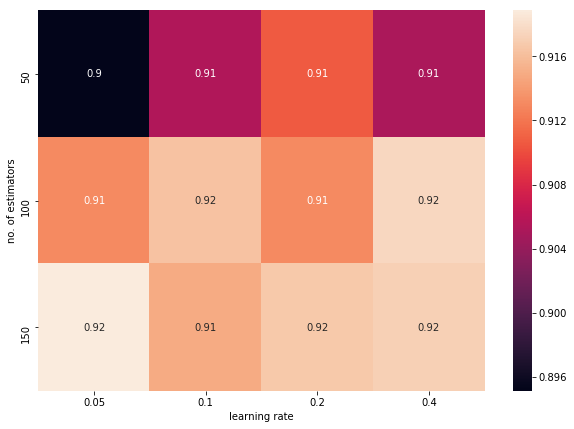

In [104]:
grid = xgb_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,4)
ind = [50,100,150]
col = [0.05,0.1,0.2,0.4]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('learning rate')
plt.ylabel('no. of estimators')

Test accuracy:  0.9208333333333333
              precision    recall  f1-score   support

          -1       0.75      0.50      0.60      3546
           1       0.94      0.98      0.96     26454

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.74      0.78     30000
weighted avg       0.91      0.92      0.91     30000



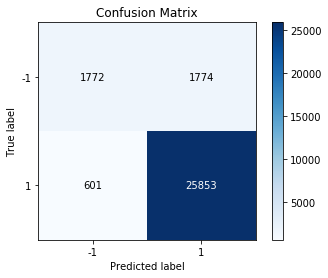

In [105]:
xgbdt = xgb.XGBClassifier(n_estimators =xgb_CV.best_params_['n_estimators'] , learning_rate = xgb_CV.best_params_['learning_rate'] , max_depth = 4 , n_jobs = -1 )
xgbdt.fit(w2vec_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',xgbdt.score(w2vec_X_test_matrix , Y_test))


test_prediction = xgbdt.predict(w2vec_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

# Tf-idf Word2Vec

In [119]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

#w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [120]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1


In [108]:
param_grid = {  'n_estimators' : [50,100,150],
              'max_depth': [ 10,30,50,70 , 90]   }  
rf = RandomForestClassifier(max_features='sqrt'  , random_state = 40 ) 
tscv = TimeSeriesSplit(n_splits=3) 
rf_CV  = GridSearchCV(estimator=rf, param_grid=param_grid , cv = tscv , scoring = 'roc_auc' , n_jobs = -1)
rf_CV.fit(tfidf_sent_vectors_X_train , Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [10, 30, 50, 70, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [109]:
# best hyperparameter
print(" best parameter:" , rf_CV.best_params_)
print("best parameter score:" ,rf_CV.best_score_ )

 best parameter: {'max_depth': 50, 'n_estimators': 150}
best parameter score: 0.8781649539326708


### ***HeatMap***

Text(69,0.5,'no. of estimator')

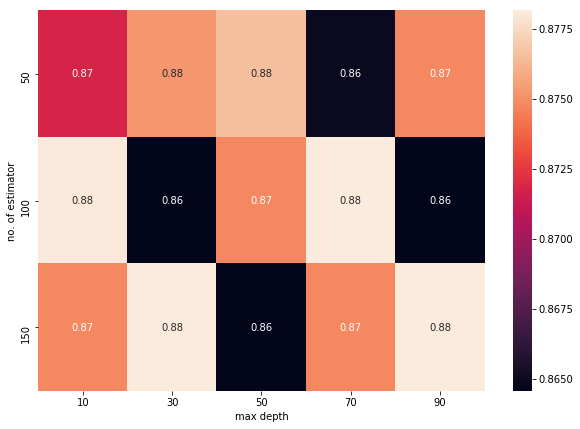

In [110]:
grid = rf_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,5)
ind = [50,100,150]
col = [10,30,50,70 , 90]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('max depth')
plt.ylabel('no. of estimator')

Test accuracy:  0.9039666666666667
              precision    recall  f1-score   support

          -1       0.81      0.25      0.38      3546
           1       0.91      0.99      0.95     26454

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.86      0.62      0.66     30000
weighted avg       0.90      0.90      0.88     30000



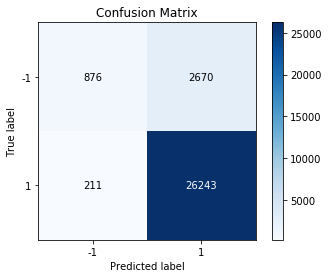

In [111]:
rf = RandomForestClassifier(n_estimators=rf_CV.best_params_['n_estimators'], max_depth =rf_CV.best_params_['max_depth'] , n_jobs=-1)
rf.fit(tfidf_sent_vectors_X_train , Y_train)

# test accuracy
print('Test accuracy: ',rf.score(tfidf_sent_vectors_X_test , Y_test))


test_prediction = rf.predict(tfidf_sent_vectors_X_test)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

## Gradient Boosting

In [129]:
base_models = [50,100,150]
v = [0.05,0.1,0.2,0.4]
param_grid = {'n_estimators': base_models,  'learning_rate':v}
xgb_model = xgb.XGBClassifier(max_depth = 4)
xgb_CV = GridSearchCV(xgb_model,param_grid,cv = 3 ,n_jobs = -1 ,  verbose=1)

In [128]:
a = np.array(tfidf_sent_vectors_X_train)

In [130]:
xgb_CV.fit(a , Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [131]:
print(" best parameter:" , xgb_CV.best_params_)
print("best parameter score:" ,xgb_CV.best_score_ )

 best parameter: {'learning_rate': 0.2, 'n_estimators': 150}
best parameter score: 0.9097428571428572


Text(69,0.5,'no. of estimators')

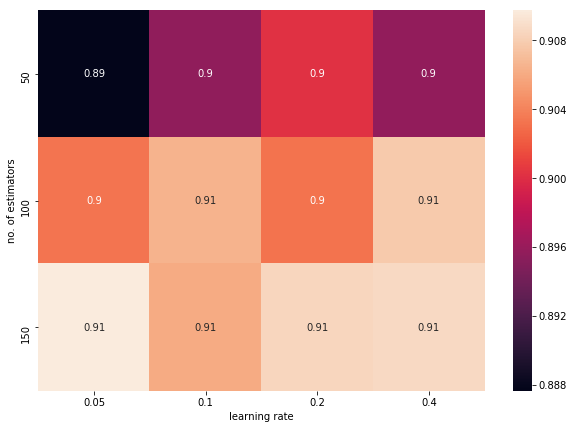

In [132]:
grid = xgb_CV.cv_results_.get('mean_test_score')

score_table= grid.reshape(3,4)
ind = [50,100,150]
col = [0.05,0.1,0.2,0.4]
df = pd.DataFrame(score_table, index = ind,
                  columns = col)

plt.figure(figsize = (10,7))
sns.heatmap(df, annot=True)
plt.xlabel('learning rate')
plt.ylabel('no. of estimators')

Test accuracy:  0.9124
              precision    recall  f1-score   support

          -1       0.73      0.41      0.52      3546
           1       0.92      0.98      0.95     26454

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.83      0.69      0.74     30000
weighted avg       0.90      0.91      0.90     30000



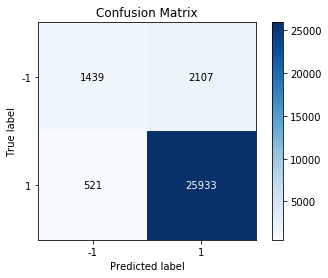

In [134]:
xgbdt = xgb.XGBClassifier(n_estimators =xgb_CV.best_params_['n_estimators'] , learning_rate = xgb_CV.best_params_['learning_rate'] , max_depth = 4 , n_jobs = -1 )
xgbdt.fit(a , Y_train)

# test accuracy
print('Test accuracy: ',xgbdt.score(tfidf_sent_vectors_X_test , Y_test))


test_prediction = xgbdt.predict(tfidf_sent_vectors_X_test)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

### Note:
 the features of word2vec and tfidf word2vec vectorization techniques are highly corelated hence directly getting important features is not possible.

## Observation 

In [10]:
from prettytable import PrettyTable
x = PrettyTable()

In [11]:
print('                                 RANDOM FOREST')
x.field_names = ["Vectorizer","Depth of tree", 'no. of estimators',"Test accuracy","f1-score"]
x.add_row(['BOW'  ,'90', '150','0.9222','0.91' ])

x.add_row(['TF-IDF' ,'90', '150','0.9225','0.91' ])

x.add_row(['W2vec'  ,'90', '150','0.9124','0.90' ])


x.add_row(['Tf-Idf W2vec' ,'90', '150','0.9039','0.88' ])

print(x)

                                 RANDOM FOREST
+--------------+---------------+-------------------+---------------+----------+
|  Vectorizer  | Depth of tree | no. of estimators | Test accuracy | f1-score |
+--------------+---------------+-------------------+---------------+----------+
|     BOW      |       90      |        150        |     0.9222    |   0.91   |
|    TF-IDF    |       90      |        150        |     0.9225    |   0.91   |
|    W2vec     |       90      |        150        |     0.9124    |   0.90   |
| Tf-Idf W2vec |       90      |        150        |     0.9039    |   0.88   |
+--------------+---------------+-------------------+---------------+----------+


In [12]:
y = PrettyTable()

In [13]:
print('                                 XG BOOST')
y.field_names = ["Vectorizer","learning rate", 'no. of estimators',"Test accuracy","f1-score"]
y.add_row(['BOW'  ,'0.3', '150','0.9363','0.93' ])

y.add_row(['TF-IDF' ,'0.3', '150','0.939','0.93' ])

y.add_row(['W2vec'  ,'0.2', '150','0.9208','0.91' ])


y.add_row(['Tf-Idf W2vec' ,'0.2', '150','0.9124','0.90' ])

print(y)

                                 XG BOOST
+--------------+---------------+-------------------+---------------+----------+
|  Vectorizer  | learning rate | no. of estimators | Test accuracy | f1-score |
+--------------+---------------+-------------------+---------------+----------+
|     BOW      |      0.3      |        150        |     0.9363    |   0.93   |
|    TF-IDF    |      0.3      |        150        |     0.939     |   0.93   |
|    W2vec     |      0.2      |        150        |     0.9208    |   0.91   |
| Tf-Idf W2vec |      0.2      |        150        |     0.9124    |   0.90   |
+--------------+---------------+-------------------+---------------+----------+


#### Conclusion
1. Performance of both algorithms on unseen  text data is quite good.Vectorization techniques like BOW and tf-Idf gave best test results
2. Random Forest reduces variance and hence can be used for building robust models through bagging.
3. XG Boost reduces both variance and bias. It reduces variance by using multiple models and reduces bias by training the subsequent model by telling them what errors previous models has made.
